In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from methods import *
from tools import *
import matplotlib.pyplot as plt
set_seaborn()
# plt.rcParams['figure.dpi'] = 300


In [3]:
import scipy
import numpy as np
from tools import *


def build_train_test_hankels(X, Y, dim, test_start, train_test_ratio):

    start = int(len(X) * test_start)
    end = start + int(len(X) * train_test_ratio)

    X_test, Y_test = X[start:end],  Y[start:end]
    X_train, Y_train = X.copy(), Y.copy()

    # use to remove from hankel later
    X_train[start:end] = np.nan

    # remove the beginning for causal convoltuion
    Y_train = np.delete(Y_train, np.arange(0, dim))
    Y_test = np.delete(Y_test, np.arange(0, dim))

    test_hankel = build_hankel(X_test, dim)
    train_hankel = build_hankel(X_train, dim)

    # remove lag vector with nan
    nan_cols = np.bitwise_or.reduce(np.isnan(train_hankel), 0)

    train_hankel = np.delete(train_hankel, nan_cols, axis=1)
    Y_train = np.delete(Y_train, nan_cols)

    return train_hankel, Y_train, test_hankel, Y_test


def train_test_method(X, Y, model, dims, train_test_ratio=0.2):

    test_start_range = np.linspace(0.0, 1.0-train_test_ratio, 100)
    T = len(test_start_range)
    B = len(dims)

    train_errors = np.zeros((B, T))
    test_errors = np.zeros((B, T))
    filters = np.zeros((B, T), dtype='O')
    all_params = np.zeros((B, T), dtype='O')
    for b, dim in enumerate(dims):
        for t, test_start in enumerate(test_start_range):

            train_hankel, Y_train, test_hankel, Y_test = build_train_test_hankels(
                X, Y, dim, test_start, train_test_ratio)
            
            P_train, theta, params = model.train(train_hankel, Y_train, dim)
            P_test = model.test(test_hankel, theta, params)
            train_err = mean_square_error(Y_train, P_train)
            test_err = mean_square_error(Y_test, P_test)

            train_errors[b, t] = train_err
            test_errors[b, t] = test_err
            filters[b, t] = theta
            all_params[b, t] = params

    return train_errors, test_errors, filters, all_params, dims


In [4]:
def convert_dtms_windowms_to_factor_dim(dt, window, TIME=1.0, LEN=10000):
    orignal_dt_ms = TIME/LEN * 1000
    factor = int(dt/orignal_dt_ms)
    dim = int(window / dt)
    return factor, dim

# downsample
def downsample(signal, factor=1):
    # take mean of all trials
    mean = np.mean(signal, axis=0)
    # down samples mean of trials
    n = len(mean) // factor
    down = []
    for i in range(0, len(mean), factor):
        m = np.mean(mean[i:i+factor])
        down.append(m)
    down = np.array(down)
    return down


In [5]:
# DATA, please cite in further usage
# Lei Zheng, Gonzalo G de Polavieja, Verena Wolfram, Musa H Asyali, Roger C Hardie, and249
# Mikko Juusola. Feedback network controls photoreceptor output at the layer of first visual250
# synapses in drosophila. The Journal of general physiology, 127(5):495–510, 2006.

# Lei Zheng, Anton Nikolaev, Trevor J Wardill, Cahir J O’Kane, Gonzalo G de Polavieja, and252
# Mikko Juusola. Network adaptation improves temporal representation of naturalistic stimuli in253
# drosophila eye: I dynamics. PLoS One, 4(1):e4307, 2009

resPH, _ = read_data('PHOTO')
res1, _ = read_data('LMC-BG1')

Data provided from: 
Lei Zheng 2006 (The Journal of general physiology, 127(5):495–510) 
Zheng 2009 (PLoS One, 4(1):e4307)
 Ask permission before usage/reproduction.

Data provided from: 
Lei Zheng 2006 (The Journal of general physiology, 127(5):495–510) 
Zheng 2009 (PLoS One, 4(1):e4307)
 Ask permission before usage/reproduction.



In [6]:

dt_ms = 2.0
lags = [20, 30, 40, 50, 60, 70, 80, 90, 100]
dims = []
train_test_ratio = 0.2
for l in lags:
    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, l)
    dims.append(dim)

X = downsample(resPH, factor=factor)
Y = downsample(res1, factor=factor)

all_results = []

model = IdentityModel()
I_res = train_test_method(X, Y, model, np.ones_like(dims), train_test_ratio=train_test_ratio)

model = LinearModel()
L_res = train_test_method(X, Y, model, dims, train_test_ratio=train_test_ratio)

model = WindowedEigModel()
E_res = train_test_method(X, Y, model, dims, train_test_ratio=train_test_ratio)



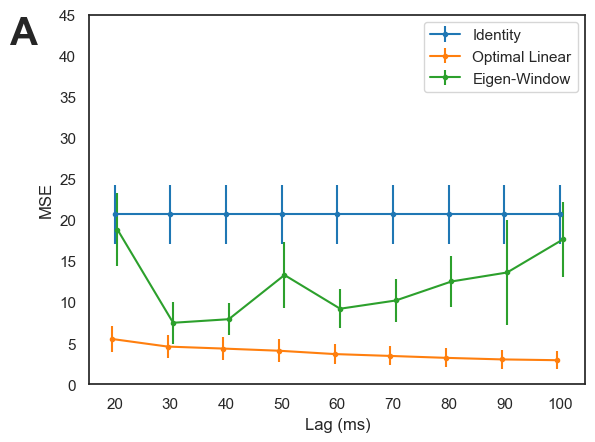

In [7]:
from matplotlib.transforms import Affine2D

res_names = zip([I_res, L_res, E_res], ['Identity',
                'Optimal Linear', 'Eigen-Window'])
                
ylims = [0, 45]
shift = [0, -0.5, 0.5]

# plot train
fig, ax = plt.subplots()
for i, (result, name) in enumerate(res_names):
    (train_errors, test_errors, filters, all_params, dims) = result
    err, std = np.mean(train_errors, axis=1), np.std(train_errors, axis=1)
    trans1 = Affine2D().translate(shift[i], 0.0) + ax.transData
    ax.errorbar(lags, err, yerr=std, label=name,  marker='.', transform=trans1)

plt.ylim(ylims)
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Lag (ms)')
plt.xticks(lags)
plt.text(-.16, .92, 'A', fontweight='bold',
         fontsize='28', transform=plt.gca().transAxes)
plt.show()



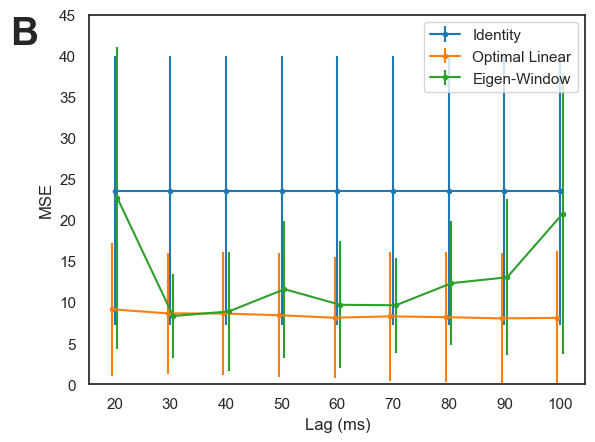

In [8]:
res_names = zip([I_res, L_res, E_res], ['Identity',
                'Optimal Linear', 'Eigen-Window'])
                
# plot test
fig, ax = plt.subplots()
for i, (result, name) in enumerate(res_names):
    (train_errors, test_errors, filters, all_params, dims) = result
    err, std = np.mean(test_errors, axis=1), np.std(test_errors, axis=1)
    trans1 = Affine2D().translate(shift[i], 0.0) + ax.transData
    ax.errorbar(lags, err, yerr=std, label=name,  marker='.', transform=trans1)

plt.ylim(ylims)
plt.legend()
plt.text(-.16, .92, 'B', fontweight='bold',
         fontsize='28', transform=plt.gca().transAxes)
plt.ylabel('MSE')
plt.xlabel('Lag (ms)')
plt.xticks(lags)
plt.show()

In [9]:
# run for one specific lag vector length and train test split


dt_ms = 2.0
lag = 30
dims = []

factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag)


X = downsample(resPH, factor=factor)
Y = downsample(res1, factor=factor)
time = np.linspace(0,1,len(X))

train_test_ratio= 0.2
test_start = 0.8
start = int(len(X) * test_start)
end = start + int(len(X) * train_test_ratio)

time_train, time_test = time[:start], time[start:end]
X_test, Y_test = X[start:end],  Y[start:end]
X_train, Y_train = X[:start], Y[:start]


model = WindowedEigModel()
trainHan = build_hankel(X_train, dim)
testHan = build_hankel(X_test, dim)
train_pred, theta, (a, b) = model.train(trainHan, Y_train[dim:], dim)
test_pred = model.test(testHan, theta, (a, b))
theta /= theta[-1]


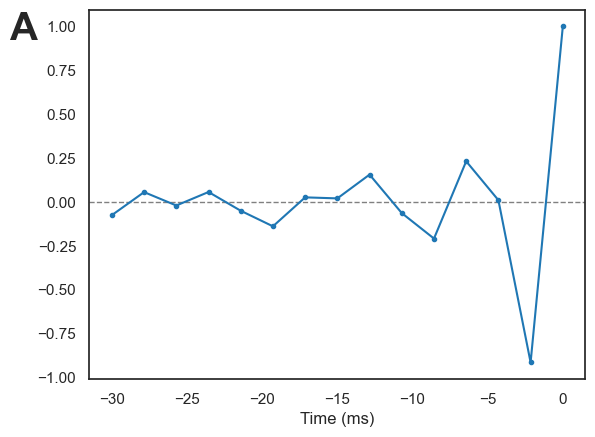

In [10]:
theta_time = np.linspace(-lag, 0, len(theta))
plt.xlabel('Time (ms)')
plt.axhline(0, linestyle='--', linewidth=1.0, color='grey')
plt.plot(theta_time, theta.real, '.-')
plt.text(-.16, .92, 'A', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()

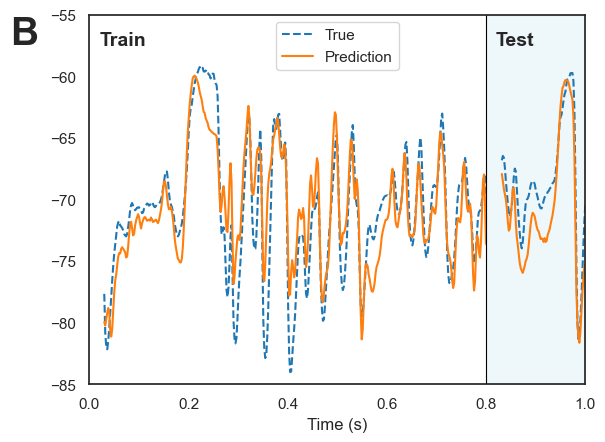

In [11]:
sns.set_style('white')
plt.plot(time_train[dim:], Y_train[dim:], '--',  label='True', color='tab:blue')
plt.plot(time_train[dim:], train_pred, label='Prediction', color='tab:orange')

plt.plot(time_test[dim:], Y_test[dim:],'--', color='tab:blue')
plt.plot(time_test[dim:], test_pred, color='tab:orange')

# plt.fill_between(np.arange(-1,0.9,0.1), -100, 100, alpha=0.2, label='Train', color='grey', hatch='-')
plt.fill_between(np.arange(0.8,2,0.1), -55, -85, alpha=0.2, color='lightblue')
plt.ylim([-85,-55])
plt.xlim([0,1])
plt.legend()
plt.axvline(0.8, lw=0.8, color='black')
plt.text(0.02, -57.5, 'Train', size=14, fontweight='bold')
plt.text(0.82, -57.5, 'Test', size=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.text(-.16, .92, 'B', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
plt.show()

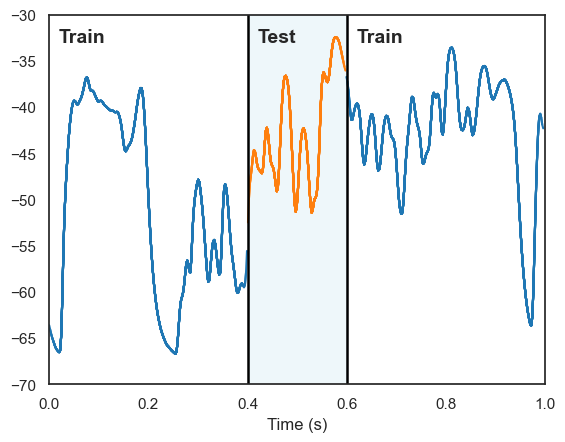

In [12]:
# run for one specific lag vector length and train test split
dt_ms = 2.0
lag = 30
dims = []

factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag)


X = downsample(resPH, factor=factor)
Y = downsample(res1, factor=factor)
time = np.linspace(0,1,len(X))

train_test_ratio= 0.2
test_start = 0.4
test_end = test_start + 1 * train_test_ratio

model = WindowedEigModel()

train_hankel, Y_train, test_hankel, Y_test = build_train_test_hankels(X, Y,dim, test_start=test_start, train_test_ratio=train_test_ratio)

offset = 0
offset2 = 0 
L = train_hankel.shape[0]
for i in range(train_hankel.shape[1]):
    lag = train_hankel[:, i]
    plt.plot(time[i:i+L], lag, color='tab:blue')
    if time[i+L] > test_start:
        offset = i+L
        offset2 = i
        break

for j in range(test_hankel.shape[1]):
    lag = test_hankel[:, j]
    plt.plot(time[offset+j:offset+j+L], lag, color='tab:orange')

offset = offset+j+L
for k in range(train_hankel.shape[1]-offset2-1):
    lag = train_hankel[:, k+offset2+1]
    plt.plot(time[offset+k:offset+k+L], lag, color='tab:blue')


plt.fill_between(np.arange(test_start,test_end,0.1), -100, 1, alpha=0.2, color='lightblue')
plt.ylim([-70,-30])
plt.xlim([0,1])

plt.axvline(test_start, lw=1.8, color='black')
plt.axvline(test_end, lw=1.8, color='black')
plt.text(0.02, -33, 'Train', size=14, fontweight='bold')
plt.text(0.62, -33, 'Train', size=14, fontweight='bold')
plt.text(0.42, -33, 'Test', size=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.show()